## 1.Environment Setup & Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, r2_score, precision_score, recall_score, f1_score
from collections import defaultdict, Counter

# Define path
data_path = '../datasets/student_grade.csv'



In [ ]:
df = pd.read_csv(data_path, low_memory=False)
df

## 2.Data Loading & Preprocessing

In [ ]:
# === 2.1 Load Data ===
df = pd.read_csv(data_path, low_memory=False)

# === 2.2 Transform Data (Wide to Long) ===
id_vars = ['student_id']
df_long = pd.melt(df, id_vars=id_vars, var_name='course', value_name='grade')

# === 2.3 Clean Data ===
# Convert grade to numeric and remove invalid/empty grades
df_long['grade'] = pd.to_numeric(df_long['grade'], errors='coerce')
df_long_cleaned = df_long[(df_long['grade'] > 0.0) & (df_long['grade'].notna())].copy()

# === 2.4 Filter for 'INT' Courses Only ===
# This ensures the model only learns from INT courses
df_long_filtered = df_long_cleaned[df_long_cleaned['course'].astype(str).str.startswith('INT')].copy()

print(f"--- Data Preparation Complete ---")
print(f"Total records after cleaning: {len(df_long_cleaned)}")
print(f"Filtered to INT courses only: {len(df_long_filtered)}")
display(df_long_filtered)


## 3.Split Data to train and test set

In [ ]:
# === 3.1 Load Data into Surprise Dataset ===
# Define rating scale (assuming grades are 1.0 to 4.0)
reader = Reader(rating_scale=(1, 4))
data = Dataset.load_from_df(df_long_filtered[['student_id', 'course', 'grade']], reader)

# === 3.2 Split Data ===
trainset, testset = train_test_split(data, test_size=0.30, random_state=42)

## 4.Model Training (KNNBasic)


In [ ]:
# === 3.3 Train the Model ===
print("--- Training KNN Model (User - User) ---")
sim_user = {
    "name": "cosine",
    "user_based": True
}

algo_user = KNNBasic(sim_options=sim_user)
algo_user.fit(trainset)
print("Training KNN Model (User - User) complete.")
print("-----------------------------------------------------")
print("--- Training KNN Model (Item - Item) ---")

sim_item = {
    "name": "cosine",
    "user_based": False
}

algo_item = KNNBasic(sim_options=sim_item)
algo_item.fit(trainset)
print("Training KNN Model (Item - Item) complete.")



In [ ]:
def recommend_for_user(algo, user_id, n=5):
    items = trainset.all_items()
    items_raw = [trainset.to_raw_iid(i) for i in items]

    predictions = [
        (iid, algo.predict(user_id, iid).est)
        for iid in items_raw
    ]

    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

In [ ]:
def similar_items(algo, item_raw_id, k=5):
    inner = algo.trainset.to_inner_iid(item_raw_id)
    neighbors = algo.get_neighbors(inner, k=k)
    raw_ids = [algo.trainset.to_raw_iid(i) for i in neighbors]
    return raw_ids

In [ ]:
recommend_for_user(algo_user, "A246", n=10) # แนะนำวิชาให้ student_id = A246

In [ ]:
similar_items(algo_item, "INT102 WEB TECHNOLOGY") # วิชาที่คล้ายกัน

## 5.Test and evaluate model

In [ ]:
# Predict on testset
pred_user = algo_user.test(testset)
pred_item = algo_item.test(testset)

# Evaluate
print("=== USER–USER KNN PERFORMANCE ===")
accuracy.rmse(pred_user)
accuracy.mae(pred_user)

print("\n=== ITEM–ITEM KNN PERFORMANCE ===")
accuracy.rmse(pred_item)
accuracy.mae(pred_item)

In [ ]:
cross_validate(algo_user, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
loo = LeaveOneOut()
for trainset, testset in loo.split(data):
    algo_user.fit(trainset)
    preds = algo_user.test(testset)

## 6.Confusion Matrix 8 grades

In [ ]:
# 1. Define Mapping: Score -> Letter
# ต้องเรียงลำดับจากน้อยไปมาก เพื่อให้ Matrix สวยงาม
score_to_letter = {
    0.0: 'F', 1.0: 'D', 1.5: 'D+', 2.0: 'C', 2.5: 'C+',
    3.0: 'B', 3.5: 'B+', 4.0: 'A'
}

# สร้าง list ของเกรดที่เป็นไปได้ (เอาไว้ระบุ Labels)
# กรองเอาเฉพาะที่มีใน map (เผื่อกรณีข้อมูลไม่มี F)
valid_scores = sorted(score_to_letter.keys())
valid_labels = [score_to_letter[s] for s in valid_scores]

# 2. Helper function: หาเกรดที่ใกล้ที่สุด
def get_nearest_grade_key(pred_score):
    # หา key (คะแนน) ที่ใกล้ที่สุด
    return min(valid_scores, key=lambda x: abs(x - pred_score))

# 3. Prepare Data
y_true_letters = []
y_pred_letters = []

for pred in pred_user:
    # 3.1 แปลง Actual Grade (r_ui) เป็น Letter
    # ใช้ get_nearest_grade_key เผื่อค่า r_ui มีทศนิยมเพี้ยนเล็กน้อย
    true_score_key = get_nearest_grade_key(pred.r_ui)
    y_true_letters.append(score_to_letter[true_score_key])

    # 3.2 แปลง Predicted Grade (est) เป็น Letter
    pred_score_key = get_nearest_grade_key(pred.est)
    y_pred_letters.append(score_to_letter[pred_score_key])

# 4. Generate Confusion Matrix
# สำคัญ: ต้องใส่ labels=valid_labels เพื่อบังคับลำดับ (D -> A)
cm = confusion_matrix(y_true_letters, y_pred_letters, labels=valid_labels)

# 5. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid_labels,
            yticklabels=valid_labels)

plt.title('Confusion Matrix: Actual vs Predicted Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.show()

# 6. Classification Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true_letters, y_pred_letters, target_names=valid_labels, zero_division=0,labels=valid_labels))

## 6.Confusion Matrix 5 grades


--- 5-Grade Classification Report ---
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         0
           D       0.76      0.03      0.05       674
           C       0.46      0.44      0.45      1671
           B       0.49      0.83      0.62      2073
           A       0.78      0.10      0.18       823

    accuracy                           0.49      5241
   macro avg       0.50      0.28      0.26      5241
weighted avg       0.56      0.49      0.42      5241



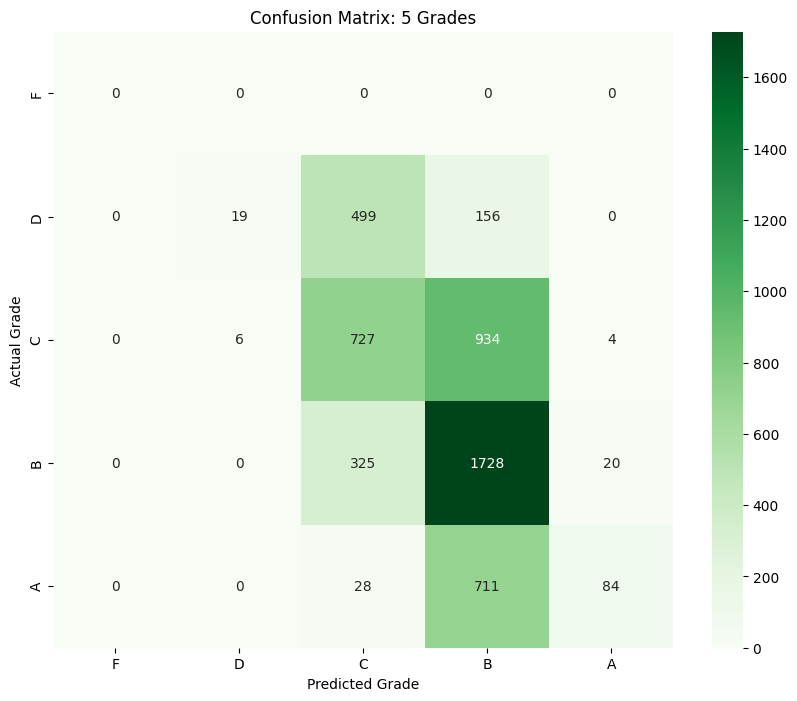

In [17]:
# Mapping: 5 Grades (Collapsing Plus grades)
score_to_letter_5 = {
    0.0: 'F', 
    1.0: 'D', 1.5: 'D', 
    2.0: 'C', 2.5: 'C',
    3.0: 'B', 3.5: 'B', 
    4.0: 'A'
}
valid_labels_5 = ['F', 'D', 'C', 'B', 'A']
# We still check against the full range of possible scores
valid_scores_all = [0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

y_true_5 = [score_to_letter_5[get_nearest_grade_key(p.r_ui)] for p in pred_user]
y_pred_5 = [score_to_letter_5[get_nearest_grade_key(p.est)] for p in pred_user]

# Plot Heatmap 5 Grades
plt.figure(figsize=(10, 8))
cm_5 = confusion_matrix(y_true_5, y_pred_5, labels=valid_labels_5)
sns.heatmap(cm_5, annot=True, fmt='d', cmap='Greens', xticklabels=valid_labels_5, yticklabels=valid_labels_5)
plt.title('Confusion Matrix: 5 Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')

print("\n--- 5-Grade Classification Report ---")
print(classification_report(y_true_5, y_pred_5, target_names=valid_labels_5, labels=valid_labels_5, zero_division=0))

## R2 Score

In [18]:
y_true_raw = [pred.r_ui for pred in pred_user]
y_pred_raw = [pred.est for pred in pred_user]

y_pred_rounded = [np.round(pred.est * 2) / 2 for pred in pred_user]

# 2. คำนวณ R2 Score
r2 = r2_score(y_true_raw, y_pred_raw)
r2Rounded = r2_score(y_true_raw, y_pred_rounded)


print(f"R2 Score: {r2:.4f}")
print(f"R2 Score Rounded: {r2Rounded:.4f}")

R2 Score: 0.3637
R2 Score Rounded: 0.3331
